Name - Ayesh Madushanka Mahamada Kalapuwage

#### Q1- Look at the above decoder code and describe any errors and Discuss how these errors could be fixed

1. Upsampling functions are not trainable which simply resizes the image by means of interpolation but Transpose functions are trainable. One argument in favor of upsampling layers could thus be that you have data required to be upsampled, while sharing quite some differences within the dataset.


My dataset includes relatively similar data, then transposed convolutions might be the better choice.

#### Q1- Now implement these solutions either by updating the code or rewriting the implementation

In [ ]:
from keras.layers import Input, Conv2D, Conv2DTranspose

def decoder_layers(inputs, layer):
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block5_conv1')(inputs)
    if layer == 1:
        return x

    x = Conv2DTranspose((2, 2), strides=2, name='decoder_block4_upsample')(x)
    x = Concatenate()(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv4')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv3')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv1')(x)
    if layer == 2:
        return x

#### Q2- Train two (or more) image decoders that can decode an image from two different convolutional layers from VGG

In [ ]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import tensorflow as tf
from pathlib import PurePath

import IPython.display as display
from IPython.display import HTML

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False
%matplotlib inline

import numpy as np
import PIL.Image
import time
import functools

In [ ]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title==None:
        title = str(image.shape)
    else:
        title += ' '+str(image.shape)
    plt.title(title)

In [ ]:
class VGG19AutoEncoder(tf.keras.Model):
    def __init__(self, files_path):
        super(VGG19AutoEncoder, self).__init__()
        #Load Full Model with every trained decoder


        #Get Each SubModel
        # Each model has an encoder, a decoder, and an extra output convolution
        # that converts the upsampled activations into output images

        # DO NOT load models four and five because they are not great auto encoders
        # and therefore will cause weird artifacts when used for style transfer

        ModelBlock3 = tf.keras.models.load_model(str(PurePath(files_path, 'Block3_Model')), compile = False)
        self.E3 = ModelBlock3.layers[0] # VGG encoder
        self.D3 = ModelBlock3.layers[1] # Trained decoder from VGG
        self.O3 = ModelBlock3.layers[2] # Conv layer to get to three channels, RGB image

        ModelBlock2 = tf.keras.models.load_model(str(PurePath(files_path, 'Block2_Model')), compile = False)
        self.E2 = ModelBlock2.layers[0] # VGG encoder
        self.D2 = ModelBlock2.layers[1] # Trained decoder from VGG
        self.O2 = ModelBlock2.layers[2] # Conv layer to get to three channels, RGB image

        # no special decoder for this one becasue VGG first layer has
        # no downsampling. So the decoder is just a convolution
        ModelBlock1 = tf.keras.models.load_model(str(PurePath(files_path, 'Block1_Model')), compile = False)
        self.E1 = ModelBlock1.layers[0] # VGG encoder, one layer
        self.O1 = ModelBlock1.layers[1] # Conv layer to get to three channels, RGB image


    def call(self, image, alphas=None, training  = False):
        # Input should be dictionary with 'style' and 'content' keys
        # {'style':style_image, 'content':content_image}
        # value in each should be a 4D Tensor,: (batch, i,j, channel)

        style_image = image['style']
        content_image = image['content']

        output_dict = dict()
        # this will be the output, where each value is a styled
        # version of the image at layer 1, 2, and 3. So each key in the
        # dictionary corresponds to layer1, layer2, and layer3.
        # we also give back the reconstructed image from the auto encoder
        # so each value in the dict is a tuple (styled, reconstructed)

        x = content_image
        # choose covariance function
        # covariance is more stable, but signal will work for very small images
        wct = self.wct_from_cov

        if alphas==None:
            alphas = {'layer3':0.6,
                      'layer2':0.6,
                      'layer1':0.6}

        # ------Layer 3----------
        # apply whiten/color on layer 3 from the original image
        # get activations
        a_c = self.E3(tf.constant(x))
        a_s = self.E3(tf.constant(style_image))
        # swap grammian of activations, blended with original
        x = wct(a_c.numpy(), a_s.numpy(), alpha=alphas['layer3'])
        # decode the new style
        x = self.O3(self.D3(x))
        x = self.enhance_contrast(x)
        # get reconstruction
        reconst3 = self.O3(self.D3(self.E3(tf.constant(content_image))))
        # save off the styled and reconstructed images for display
        blended3 = tf.clip_by_value(tf.squeeze(x), 0, 1)
        reconst3 = tf.clip_by_value(tf.squeeze(reconst3), 0, 1)
        output_dict['layer3'] = (blended3, reconst3)

        # ------Layer 2----------
        # apply whiten/color on layer 2 from the already blended image
        # get activations
        a_c = self.E2(tf.constant(x))
        a_s = self.E2(tf.constant(style_image))
        # swap grammian of activations, blended with original
        x = wct(a_c.numpy(),a_s.numpy(), alpha=alphas['layer2'])
        # decode the new style
        x = self.O2(self.D2(x))
        x = self.enhance_contrast(x,1.3)
        # get reconstruction
        reconst2 = self.O2(self.D2(self.E2(tf.constant(content_image))))
        # save off the styled and reconstructed images for display
        blended2 = tf.clip_by_value(tf.squeeze(x), 0, 1)
        reconst2 = tf.clip_by_value(tf.squeeze(reconst2), 0, 1)
        output_dict['layer2'] = (blended2, reconst2)

        # ------Layer 1----------
        # apply whiten/color on layer 1 from the already blended image
        # get activations
        a_c = self.E1(tf.constant(x))
        a_s = self.E1(tf.constant(style_image))
        # swap grammian of activations, blended with original
        x = wct(a_c.numpy(),a_s.numpy(), alpha=alphas['layer1'])
        # decode the new style
        x = self.O1(x)
        x = self.enhance_contrast(x,1.2)
        # get reconstruction
        reconst1 = self.O1(self.E1(tf.constant(content_image)))
        # save off the styled and reconstructed images for display
        blended1 = tf.clip_by_value(tf.squeeze(x), 0, 1)
        reconst1 = tf.clip_by_value(tf.squeeze(reconst1), 0, 1)
        output_dict['layer1'] = (blended1, reconst1)

        return output_dict

    @staticmethod
    def enhance_contrast(image, factor=1.25):
        return tf.image.adjust_contrast(image,factor)

    @staticmethod
    def wct_from_cov(content, style, alpha=0.6, eps=1e-5):
        '''
        https://github.com/eridgd/WCT-TF/blob/master/ops.py
           Perform Whiten-Color Transform on feature maps using numpy
           See p.4 of the Universal Style Transfer paper for equations:
           https://arxiv.org/pdf/1705.08086.pdf
        '''
        # 1xHxWxC -> CxHxW
        content_t = np.transpose(np.squeeze(content), (2, 0, 1))
        style_t = np.transpose(np.squeeze(style), (2, 0, 1))

        # CxHxW -> CxH*W
        content_flat = content_t.reshape(-1, content_t.shape[1]*content_t.shape[2])
        style_flat = style_t.reshape(-1, style_t.shape[1]*style_t.shape[2])

        # applt a threshold for only the largets eigen values
        eigen_val_thresh = 1e-5

        # ===Whitening transform===
        # 1. take mean of each channel
        mc = content_flat.mean(axis=1, keepdims=True)
        fc = content_flat - mc
        # 2. get covariance of content, take SVD
        cov_c = np.dot(fc, fc.T) / (content_t.shape[1]*content_t.shape[2] - 1)
        Uc, Sc, _ = np.linalg.svd(cov_c)
        # 3. truncate the SVD to only the largest eigen values
        k_c = (Sc > eigen_val_thresh).sum()
        Dc = np.diag((Sc[:k_c]+eps)**-0.5)
        Uc = Uc[:,:k_c]
        # 4. Now make a whitened content image
        fc_white = (Uc @ Dc @ Uc.T) @ fc

        # ===Coloring transform===
        # 1. take mean of each channel
        ms = style_flat.mean(axis=1, keepdims=True)
        fs = style_flat - ms
        # 2. get covariance of style, take SVD
        cov_s = np.dot(fs, fs.T) / (style_t.shape[1]*style_t.shape[2] - 1)
        Us, Ss, _ = np.linalg.svd(cov_s)
        # 3. truncate the SVD to only the largest eigen values
        k_s = (Ss > eigen_val_thresh).sum()
        Ds = np.sqrt(np.diag(Ss[:k_s]+eps))
        Us = Us[:,:k_s]
        # 4. Now make a colored image that mixes the Grammian of the style
        #   with the whitened content image
        fcs_hat = (Us @ Ds @ Us.T) @ fc_white
        fcs_hat = fcs_hat + ms # add style mean back to each channel

        # Blend transform features with original features
        blended = alpha*fcs_hat + (1 - alpha)*(content_flat)

        # CxH*W -> CxHxW
        blended = blended.reshape(content_t.shape)
        # CxHxW -> 1xHxWxC
        blended = np.expand_dims(np.transpose(blended, (1,2,0)), 0)

        return np.float32(blended)

    @staticmethod
    def wct_from_signal(content, style, alpha=0.6 ):
        # This uses a more computational SVD decomposition to get the Grammian
        # to match. However, the numerical precision makes this totally fail
        # if the activations are too large.
        # This code is only for reference based on our discussion of WCT

        # 1xHxWxC -> CxHxW
        content_t = np.transpose(np.squeeze(content), (2, 0, 1))
        style_t = np.transpose(np.squeeze(style), (2, 0, 1))

        # CxHxW -> Cx(H*W)
        content_flat = content_t.reshape(-1, content_t.shape[1]*content_t.shape[2])
        style_flat = style_t.reshape(-1, style_t.shape[1]*style_t.shape[2])

        singular_val_thresh = 1e-3
        #-------------------------------------------
        # Whitening transform and Coloring transform
        # 1. SVD of content signals
        mc = content_flat.mean()
        fc = content_flat - mc
        Uc, Sc, Vc = np.linalg.svd(fc, full_matrices=False)
        k_c = (Sc > singular_val_thresh).sum()

        # 2. SVD of style signals
        ms = style_flat.mean()
        fs = style_flat - ms
        Us, Ss, Vs = np.linalg.svd(fs, full_matrices=False)
        k_s = (Ss > singular_val_thresh).sum()

        k = min(k_s,k_c)

        # Blend transform features with original features
        fcs = (Us[:,:k] @ np.diag(Ss[:k]) @ Vc[:k,:]) + mc
        blended = alpha*fcs + (1 - alpha)*(content_flat)

        # CxH*W -> CxHxW
        blended = blended.reshape(content_t.shape)
        # CxHxW -> 1xHxWxC
        blended = np.expand_dims(np.transpose(blended, (1,2,0)), 0)

        return np.float32(blended)


In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('vgg_decoder')


Mounted at vgg_decoder


In [ ]:
%%time

AE = VGG19AutoEncoder('/content/vgg_decoder/MyDrive/ML3/ML_assignment03/vgg_decoder')

CPU times: user 3.58 s, sys: 275 ms, total: 3.85 s
Wall time: 7.21 s


CPU times: user 17.5 s, sys: 1.39 s, total: 18.9 s
Wall time: 15.5 s


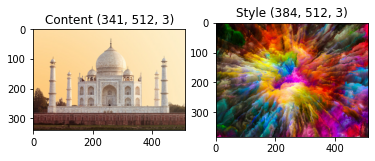

In [ ]:
%%time

from skimage.transform import resize

content_path = '/content/vgg_decoder/MyDrive/ML3/ML_assignment03/taj_mahal2.jpeg'
style_path = '/content/vgg_decoder/MyDrive/ML3/ML_assignment03/style2.jpeg'

content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image,'Content')

plt.subplot(1, 2, 2)
imshow(style_image,'Style')

tmp = {'style':style_image,
       'content':content_image}

alphas = {'layer3':0.8, 'layer2':0.6, 'layer1':0.6}
decoded_images = AE(tmp, alphas=alphas)

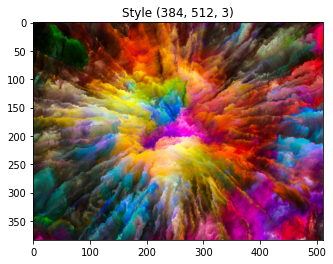

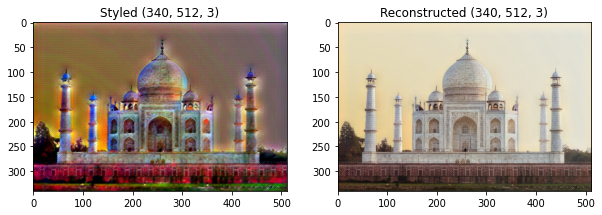

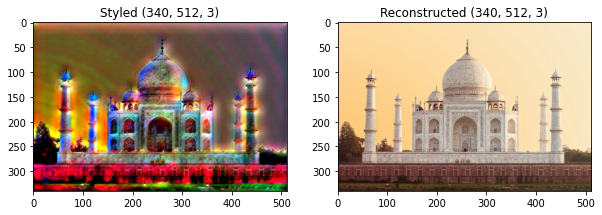

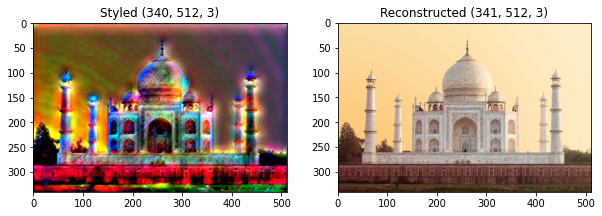

In [ ]:
import cv2
import numpy as np

reconstruction = []
style = []
imshow(style_image,'Style')
for layer in decoded_images.keys():
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    imshow(decoded_images[layer][0],'Styled')
    plt.subplot(1,2,2)
    imshow(decoded_images[layer][1],'Reconstructed')


In [ ]:
kk = decoded_images.get('layer1')
style = []
reconstruct = []
for layer in decoded_images.keys():
    ll=decoded_images[layer][0]
    style.append(ll)
    kk = decoded_images[layer][1]
    reconstruct.append(kk)

#### Q3- Show a few images and their reconstructions using each decoder. Comment on any artifacts from the images. For full credit, the decoding of the images should look similar and the performance should be discussed.  

I almost couldn't find the difference between original and reconstructed image. I could say recostructed image is more than 95% similar to the original.

#### Q4- Implement the whitening and coloring transform (WCT) as described by Li et al. An implementation of this has already been written for you, available in the link above and in the class master repository.  You should use an SVD decomposition of the covariance (NOT an SVD of the activations).

The styled images are also in presented in above

## Q5 last part

# Implement a style transfer addition of your choosing(GIF_smoothing)

In [ ]:
from __future__ import division
from PIL import Image
from torch import nn
import numpy as np
import cv2
from cv2.ximgproc import guidedFilter


class GIFSmoothing(nn.Module):
    def forward(self, *input):
        pass

    def __init__(self, r, eps):
        super(GIFSmoothing, self).__init__()
        self.r = r
        self.eps = eps

    def process(self, initImg, contentImg):
        return self.process_opencv(initImg, contentImg)

    def process_opencv(self, initImg, contentImg):
        '''
        :param initImg: intermediate output. Either image path or PIL Image
        :param contentImg: content image output. Either path or PIL Image
        :return: stylized output image. PIL Image
        '''
        if type(initImg) == str:
            init_img = cv2.imread(initImg)
            #init_img = init_img[2:-2,2:-2,:]
        else:
            init_img = np.array(initImg)[:, :, ::-1].copy()

        if type(contentImg) == str:
            cont_img = cv2.imread(contentImg)
        else:
            cont_img = np.array(contentImg)[:, :, ::-1].copy()

        output_img = guidedFilter(guide=cont_img, src=init_img, radius=self.r, eps=self.eps)
        output_img = cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB)
        output_img = Image.fromarray(output_img)
        return output_img

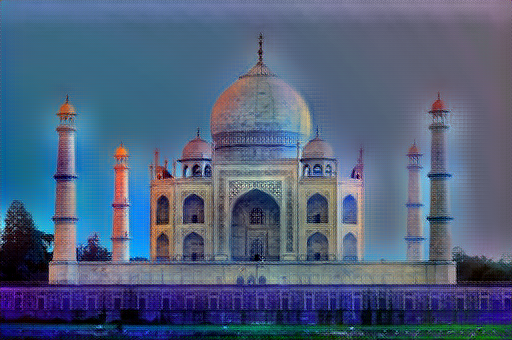

In [ ]:
gif_smooting  = GIFSmoothing(15, 1e-1)
First_smooth = gif_smooting.process('/content/vgg_decoder/MyDrive/ML3/ML_assignment03/inter_style1.png', '/content/vgg_decoder/MyDrive/ML3/ML_assignment03/content_int_1.png')
First_smooth

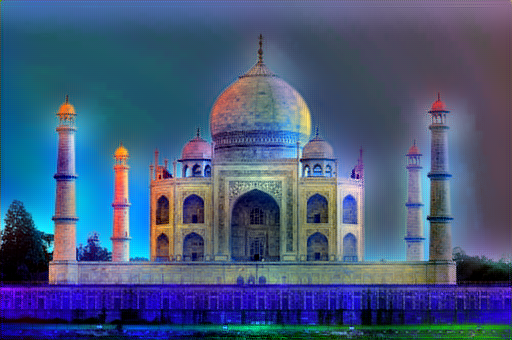

In [ ]:
Second_smooth = gif_smooting.process('/content/vgg_decoder/MyDrive/ML3/ML_assignment03/inter_style2.png', '/content/vgg_decoder/MyDrive/ML3/ML_assignment03/content_int_2.png')
Second_smooth

In [ ]:
!pip install scipy==1.2.2

     |████████████████████████████████| 24.8 MB 12.9 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


# SMOOTHIG_Laplacian

In [ ]:
from __future__ import division
import torch.nn as nn
import scipy.misc
import numpy as np
import scipy.sparse
import scipy.sparse.linalg
from numpy.lib.stride_tricks import as_strided
from PIL import Image
import imageio


class Propagator(nn.Module):
    def __init__(self, beta=0.9999):
        super(Propagator, self).__init__()
        self.beta = beta

    def process(self, initImg, contentImg):

        if type(contentImg) == str:
            content = imageio.imread(contentImg, pilmode="RGB")
        else:
            content = contentImg.copy()
        # content = scipy.misc.imread(contentImg, mode='RGB')

        if type(initImg) == str:
            B = imageio.imread(initImg, pilmode="RGB").astype(np.float64) / 255
        else:
            B = scipy.asarray(initImg).astype(np.float64) / 255
            # B = self.
        # B = scipy.misc.imread(initImg, mode='RGB').astype(np.float64)/255
        h1,w1,k = B.shape
        h = h1 - 4
        w = w1 - 4
        B = B[int((h1-h)/2):int((h1-h)/2+h),int((w1-w)/2):int((w1-w)/2+w),:]
        content = scipy.misc.imresize(content,(h,w))
        B = self.__replication_padding(B,2)
        content = self.__replication_padding(content,2)
        content = content.astype(np.float64)/255
        B = np.reshape(B,(h1*w1,k))
        W = self.__compute_laplacian(content)
        W = W.tocsc()
        dd = W.sum(0)
        dd = np.sqrt(np.power(dd,-1))
        dd = dd.A.squeeze()
        D = scipy.sparse.csc_matrix((dd, (np.arange(0,w1*h1), np.arange(0,w1*h1)))) # 0.026
        S = D.dot(W).dot(D)
        A = scipy.sparse.identity(w1*h1) - self.beta*S
        A = A.tocsc()
        solver = scipy.sparse.linalg.factorized(A)
        V = np.zeros((h1*w1,k))
        V[:,0] = solver(B[:,0])
        V[:,1] = solver(B[:,1])
        V[:,2] = solver(B[:,2])
        V = V*(1-self.beta)
        V = V.reshape(h1,w1,k)
        V = V[2:2+h,2:2+w,:]

        img = Image.fromarray(np.uint8(np.clip(V * 255., 0, 255.)))
        return img

    # Returns sparse matting laplacian
    # The implementation of the function is heavily borrowed from
    # https://github.com/MarcoForte/closed-form-matting/blob/master/closed_form_matting.py
    # We thank Marco Forte for sharing his code.
    def __compute_laplacian(self, img, eps=10**(-7), win_rad=1):
            win_size = (win_rad*2+1)**2
            h, w, d = img.shape
            c_h, c_w = h - 2*win_rad, w - 2*win_rad
            win_diam = win_rad*2+1
            indsM = np.arange(h*w).reshape((h, w))
            ravelImg = img.reshape(h*w, d)
            win_inds = self.__rolling_block(indsM, block=(win_diam, win_diam))
            win_inds = win_inds.reshape(c_h, c_w, win_size)
            winI = ravelImg[win_inds]
            win_mu = np.mean(winI, axis=2, keepdims=True)
            win_var = np.einsum('...ji,...jk ->...ik', winI, winI)/win_size - np.einsum('...ji,...jk ->...ik', win_mu, win_mu)
            inv = np.linalg.inv(win_var + (eps/win_size)*np.eye(3))
            X = np.einsum('...ij,...jk->...ik', winI - win_mu, inv)
            vals = (1/win_size)*(1 + np.einsum('...ij,...kj->...ik', X, winI - win_mu))
            nz_indsCol = np.tile(win_inds, win_size).ravel()
            nz_indsRow = np.repeat(win_inds, win_size).ravel()
            nz_indsVal = vals.ravel()
            L = scipy.sparse.coo_matrix((nz_indsVal, (nz_indsRow, nz_indsCol)), shape=(h*w, h*w))
            return L

    def __replication_padding(self, arr,pad):
            h,w,c = arr.shape
            ans = np.zeros((h+pad*2,w+pad*2,c))
            for i in range(c):
                    ans[:,:,i] = np.pad(arr[:,:,i],pad_width=(pad,pad),mode='edge')
            return ans

    def __rolling_block(self, A, block=(3, 3)):
        shape = (A.shape[0] - block[0] + 1, A.shape[1] - block[1] + 1) + block
        strides = (A.strides[0], A.strides[1]) + A.strides
        return as_strided(A, shape=shape, strides=strides)

In [ ]:
laplace_smooth = Propagator()

In [ ]:
fir_smoo = laplace_smooth.process('/content/vgg_decoder/MyDrive/ML3/ML_assignment03/inter_style1.png', '/content/vgg_decoder/MyDrive/ML3/ML_assignment03/content_int_1.png')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
    Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


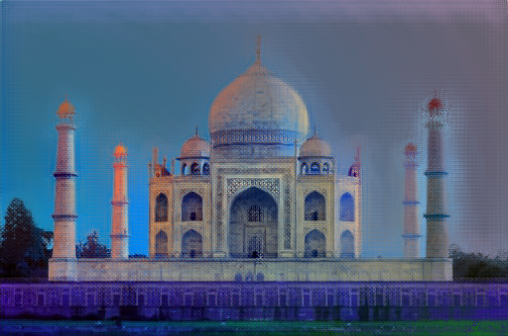

In [ ]:
fir_smoo

In [ ]:
seco_smooth = laplace_smooth.process('/content/vgg_decoder/MyDrive/ML3/ML_assignment03/inter_style2.png', '/content/vgg_decoder/MyDrive/ML3/ML_assignment03/content_int_2.png')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
    Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


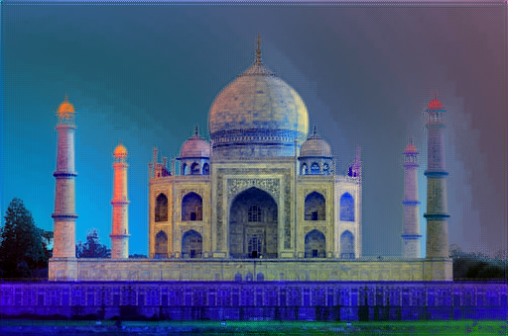

In [ ]:
seco_smooth

# color preserving style transfer

In [ ]:
def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114])


def gray2rgb(gray):
    w, h = gray.shape
    rgb = np.empty((w, h, 3), dtype=np.float32)
    rgb[:, :, 2] = rgb[:, :, 1] = rgb[:, :, 0] = gray
    return rgb

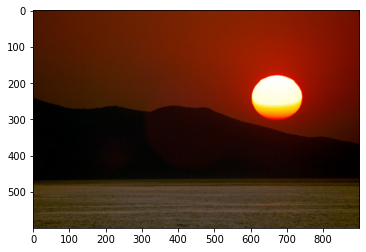

In [ ]:
from keras.preprocessing import image
content = image.load_img('/content/vgg_decoder/MyDrive/ML3/ML_assignment03/sun.jpeg')
imshow(content)

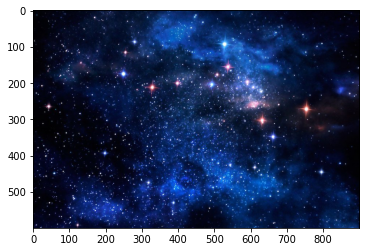

In [ ]:
styled = image.load_img('/content/vgg_decoder/MyDrive/ML3/ML_assignment03/srat_sty.jpeg')
imshow(styled)


In [ ]:
def colur_transfer(content, styled):
  #content = cv2.imread('/content/vgg_decoder/MyDrive/ML3/ML_assignment03/content_int_1.png')
  #styled = cv2.imread('/content/vgg_decoder/MyDrive/ML3/ML_assignment03/inter_style2.png')
  original_image = np.clip(content, 0, 255)
  styled_image = np.clip(styled, 0, 255)
# Luminosity transfer steps:
# 1. Convert stylized RGB->grayscale accoriding to Rec.601 luma (0.299, 0.587, 0.114)
# 2. Convert stylized grayscale into YUV (YCbCr)
# 3. Convert original image into YUV (YCbCr)
# 4. Recombine (stylizedYUV.Y, originalYUV.U, originalYUV.V)
# 5. Convert recombined image from YUV back to RGB

 # 1
  styled_grayscale = rgb2gray(styled_image)
  styled_grayscale_rgb = gray2rgb(styled_grayscale)
#styled_grayscale_rgb.shape
 # 2
  styled_grayscale_yuv = np.array(Image.fromarray(styled_grayscale_rgb.astype(np.uint8)).convert("YCbCr"))
#styled_grayscale_yuv.shape
# 3
  original_yuv = np.array(Image.fromarray(original_image.astype(np.uint8)).convert("YCbCr"))
  original_yuv.shape
 # 4
  w, h, _ = original_image.shape
  combined_yuv = np.empty((w, h, 3), dtype=np.uint8)
  combined_yuv[..., 0] = styled_grayscale_yuv[..., 0]
  combined_yuv[..., 1] = original_yuv[..., 1]
  combined_yuv[..., 2] = original_yuv[..., 2]

# # 5
  img_out = np.array(Image.fromarray(combined_yuv, "YCbCr").convert("RGB"))
  return img_out

In [ ]:
colout_luminus = colur_transfer(content,styled)

In [ ]:
cv2.imwrite('/content/vgg_decoder/MyDrive/ML3/ML_assignment03/luminous1.png', colout_luminus )

True

In [ ]:
from tensorflow import keras
#content_image = tf.keras.utils.load_img('/content/vgg_decoder/MyDrive/ML3/ML_assignment03/luminous1.png')

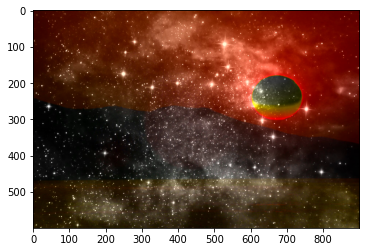

In [ ]:
from keras.preprocessing import image
white_style_1 = image.load_img('/content/vgg_decoder/MyDrive/ML3/ML_assignment03/luminous1.png')
imshow(white_style_1)

We can see colourful stars in the style image become colourless in the final image.

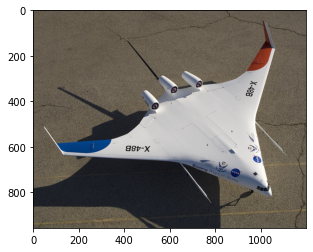

In [ ]:
content = image.load_img('/content/vgg_decoder/MyDrive/ML3/ML_assignment03/jet.jpeg')
imshow(content)

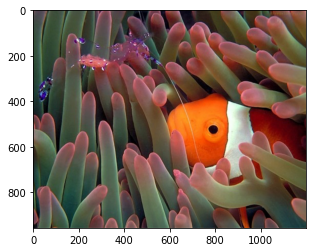

In [ ]:
styled = image.load_img('/content/vgg_decoder/MyDrive/ML3/ML_assignment03/fish_style.jpeg')
imshow(styled)

In [ ]:
colout_luminus2 = colur_transfer(content,styled)

In [ ]:
cv2.imwrite('/content/vgg_decoder/MyDrive/ML3/ML_assignment03/luminous2.png', colout_luminus2 )

True

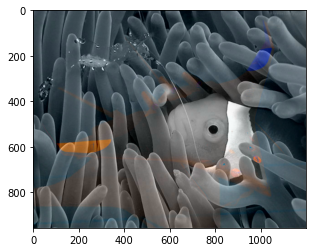

In [ ]:
white_style_2 = image.load_img('/content/vgg_decoder/MyDrive/ML3/ML_assignment03/luminous2.png')
imshow(white_style_2)

As like in the first test style colours colourless and preserved content colour.

I tried to finish this on time but I got several errors on my computer and I couldn't find the solutions because all the most of the packages were interrupted with each other. Final error was Mac OS error. Then I used google colab. I totally apologizeabout late. Herewith attached screen shot of final error. 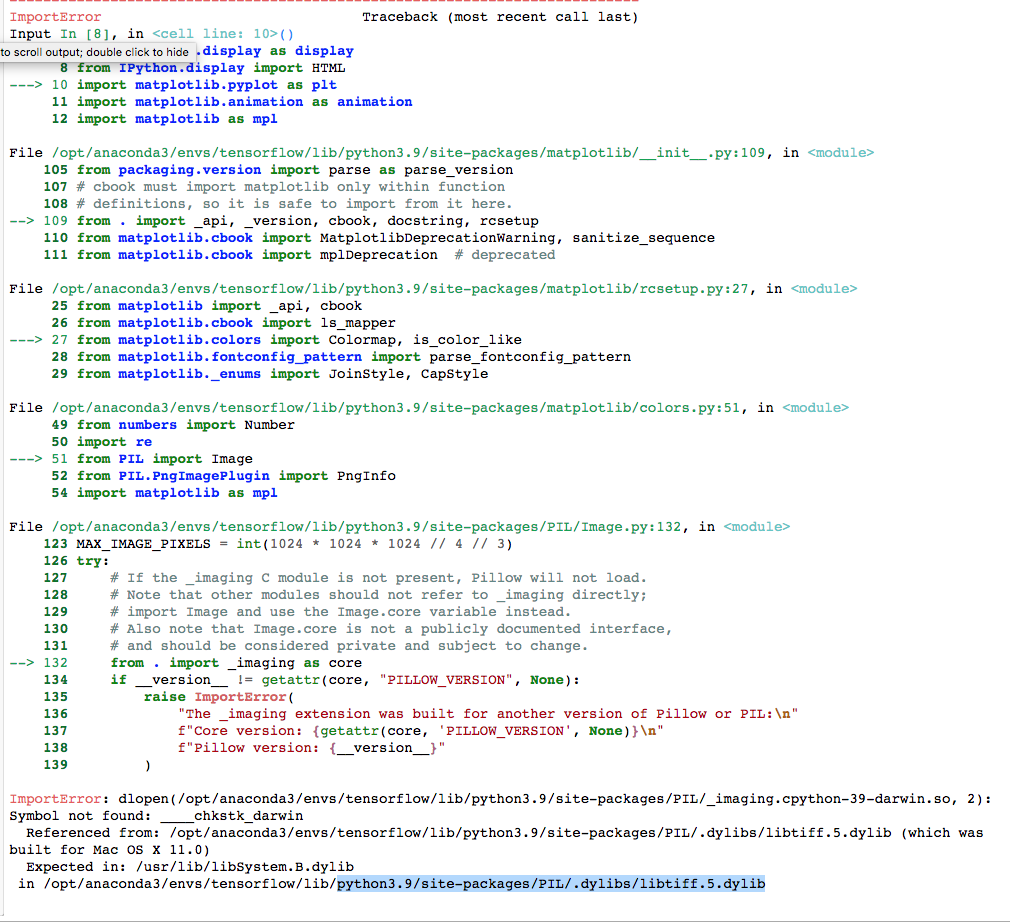